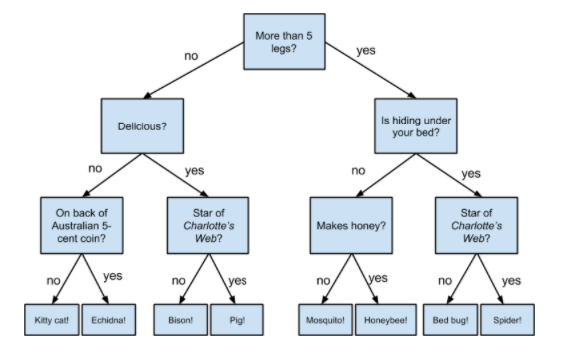

## Entropy

In [ ]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    """Given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in class_probabilities
               if p > 0)                     # ignore zero probabilities

assert entropy([1.0]) == 0
assert entropy([0.5, 0.5]) == 1
assert 0.81 < entropy([0.25, 0.75]) < 0.82

In [ ]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

assert data_entropy(['a']) == 0
assert data_entropy([True, False]) == 1
assert data_entropy([3, 4, 4, 4]) == entropy([0.25, 0.75])

## The Entropy of a Partition

In [ ]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

## Creating a Decision Tree

In [ ]:
from typing import NamedTuple, Optional

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None  # allow unlabeled data

                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

In [ ]:
from typing import Dict, TypeVar
from collections import defaultdict

T = TypeVar('T')  # generic type for inputs

def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List[T]]:
    """Partition the inputs into lists based on the specified attribute."""
    partitions: Dict[Any, List[T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)  # value of the specified attribute
        partitions[key].append(input)    # add input to the correct partition
    return partitions

In [ ]:
def partition_entropy_by(inputs: List[Any],
                         attribute: str,
                         label_attribute: str) -> float:
    """Compute the entropy corresponding to the given partition"""
    # partitions consist of our inputs
    partitions = partition_by(inputs, attribute)

    # but partition_entropy needs just the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
              for partition in partitions.values()]

    return partition_entropy(labels)

In [ ]:
for key in ['level','lang','tweets','phd']:
    print(key, partition_entropy_by(inputs, key, 'did_well'))

assert 0.69 < partition_entropy_by(inputs, 'level', 'did_well')  < 0.70
assert 0.86 < partition_entropy_by(inputs, 'lang', 'did_well')   < 0.87
assert 0.78 < partition_entropy_by(inputs, 'tweets', 'did_well') < 0.79
assert 0.89 < partition_entropy_by(inputs, 'phd', 'did_well')    < 0.90

In [ ]:
senior_inputs = [input for input in inputs if input.level == 'Senior']

assert 0.4 == partition_entropy_by(senior_inputs, 'lang', 'did_well')
assert 0.0 == partition_entropy_by(senior_inputs, 'tweets', 'did_well')
assert 0.95 < partition_entropy_by(senior_inputs, 'phd', 'did_well') < 0.96

## Putting It All Together

In [ ]:
from typing import NamedTuple, Union, Any

class Leaf(NamedTuple):
    value: Any

class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

In [ ]:
hiring_tree = Split('level', {   # first, consider "level"
    'Junior': Split('phd', {     # if level is "Junior", next look at "phd"
        False: Leaf(True),       #   if "phd" is False, predict True
        True: Leaf(False)        #   if "phd" is True, predict False
    }),
    'Mid': Leaf(True),           # if level is "Mid", just predict True
    'Senior': Split('tweets', {  # if level is "Senior", look at "tweets"
        False: Leaf(False),      #   if "tweets" is False, predict False
        True: Leaf(True)         #   if "tweets" is True, predict True
    })
})

In [ ]:
def classify(tree: DecisionTree, input: Any) -> Any:
    """classify the input using the given decision tree"""

    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.

In [ ]:
def build_tree_id3(inputs: List[Any],
                   split_attributes: List[str],
                   target_attribute: str) -> DecisionTree:
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute)
                           for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]

    # If there's a unique label, predict it
    if len(label_counts) == 1:
        return Leaf(most_common_label)

    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)

    # Otherwise split by the best attribute

    def split_entropy(attribute: str) -> float:
        """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, attribute, target_attribute)

    best_attribute = min(split_attributes, key=split_entropy)

    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a != best_attribute]

    # Recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset,
                                                 new_attributes,
                                                 target_attribute)
                for attribute_value, subset in partitions.items()}

    return Split(best_attribute, subtrees, default_value=most_common_label)

In [ ]:
tree = build_tree_id3(inputs,
                      ['level', 'lang', 'tweets', 'phd'],
                      'did_well')

# Should predict True
assert classify(tree, Candidate("Junior", "Java", True, False))

# Should predict False
assert not classify(tree, Candidate("Junior", "Java", True, True))

In [ ]:
# Should predict True
assert classify(tree, Candidate("Intern", "Java", True, True))

## Random Forests

In [ ]:
# if there are already few enough split candidates, look at all of them
    if len(split_candidates) <= self.num_split_candidates:
        sampled_split_candidates = split_candidates
    # otherwise pick a random sample
    else:
        sampled_split_candidates = random.sample(split_candidates,
                                                 self.num_split_candidates)

    # now choose the best attribute only from those candidates
    best_attribute = min(sampled_split_candidates, key=split_entropy)

    partitions = partition_by(inputs, best_attribute)

- https://xgboost.ai/